In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType

In [2]:
ENDPOINT = "https://softwarepark-face-api.cognitiveservices.azure.com/"
KEY = "30d0899c3a6c4a10b2e6bdc3e2d19ddc"

face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [23]:
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))
def get_path(p):
    return os.path.join("/home/jupyter/images/", p)

def mark_faces(file, detected_faces):
    img = Image.open(get_path(file))

    # For each face returned use the face rectangle and draw a red box.
    draw = ImageDraw.Draw(img)
    for face in detected_faces:
        draw.rectangle(getRectangle(face), outline='pink', width=3)

    img.thumbnail((600,600), Image.ANTIALIAS)
    return img

def detect_faces(file):
    
    # Detect a face in an image that contains a single face
    

    with open(get_path(file), 'r+b') as f:
        profile_faces = face_client.face.detect_with_stream(f)
    if not profile_faces:
        raise Exception('No profile detected from image {}'.format(file))
    return profile_faces
    

Same person, 0.65364


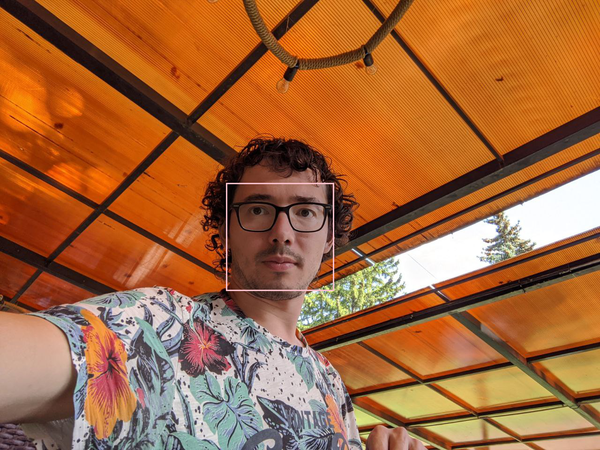

In [24]:
profile_name = 'rinat_avatar.jpg'
scene_name = "rinat_identify.jpg"

profile_faces = detect_faces(profile_path)
detected_faces = detect_faces(scene_name)

result = face_client.face.verify_face_to_face(profile_face.face_id, detected_faces[0].face_id)
print(f'{"Same" if result.is_identical else "Different "} person, {result.confidence}')

mark_faces(scene_name, detected_faces)

In [6]:
import argparse
import glob
import logging
import os
import sys

import tensorflow as tf

logging.getLogger('tensorflow').disabled = True

import numpy as np
from fawkes.differentiator import FawkesMaskGeneration
from fawkes.utils import load_extractor, init_gpu, select_target_label, dump_image, reverse_process_cloaked, \
    Faces, filter_image_paths

from fawkes.align_face import aligner
from fawkes.utils import get_file
from fawkes.protection import Fawkes

In [7]:
gpu = 0
batch_size = 1
feature_extractor = "high_extract"
protector = Fawkes(feature_extractor, 0, batch_size)

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument('--directory', '-d', type=str,
                    help='the directory that contains images to run protection', default='imgs/')

parser.add_argument('--gpu', '-g', type=str,
                    help='the GPU id when using GPU for optimization', default='0')

parser.add_argument('--mode', '-m', type=str,
                    help='cloak generation mode, select from min, low, mid, high. The higher the mode is, the more perturbation added and stronger protection',
                    default='min')

parser.add_argument('--feature-extractor', type=str,
                    help="name of the feature extractor used for optimization, currently only support high_extract",
                    default="high_extract")

parser.add_argument('--th', help='only relevant with mode=custom, DSSIM threshold for perturbation', type=float,
                    default=0.01)
parser.add_argument('--max-step', help='only relevant with mode=custom, number of steps for optimization', type=int,
                    default=1000)
parser.add_argument('--sd', type=int, help='only relevant with mode=custom, penalty number, read more in the paper',
                    default=1e9)
parser.add_argument('--lr', type=float, help='only relevant with mode=custom, learning rate', default=2)

parser.add_argument('--batch-size', help="number of images to run optimization together", type=int, default=1)
parser.add_argument('--separate_target', help="whether select separate targets for each faces in the directory",
                    action='store_true')
parser.add_argument('--no-align', help="whether to detect and crop faces",
                    action='store_true')
parser.add_argument('--debug', help="turn on debug and copy/paste the stdout when reporting an issue on github",
                    action='store_true')
parser.add_argument('--format', type=str,
                    help="format of the output image",
                    default="png")



In [28]:
args = parser.parse_args([])
args.mode="ultra"
protector.run_protection([get_path(profile_name)], mode=args.mode, th=args.th, sd=args.sd, lr=args.lr,
                                 max_step=args.max_step,
                                 batch_size=args.batch_size, format=args.format,
                                 separate_target=args.separate_target, debug=args.debug, no_align=args.no_align)

Please enable GPU for ultra setting...


SystemExit: 1

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Original: Same person, 0.65364
Cloaked: Same person, 0.54794


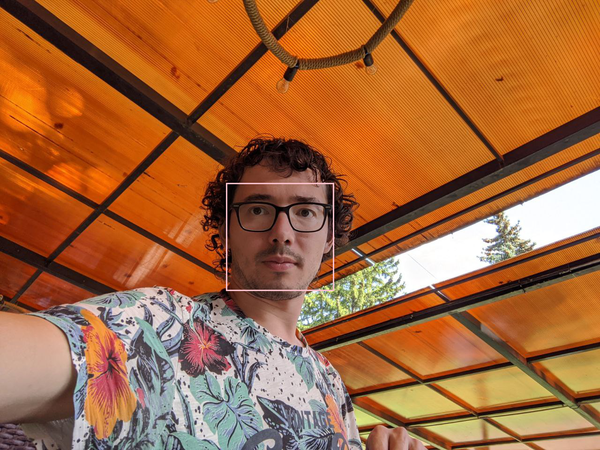

In [27]:
original_face = detect_faces("rinat_avatar.jpg")[0]
cloaked_face = detect_faces("rinat_profile_high_cloaked.png")[0]

result = face_client.face.verify_face_to_face(original_face.face_id, detected_faces[0].face_id)
print(f'Original: {"Same" if result.is_identical else "Different "} person, {result.confidence}')

result = face_client.face.verify_face_to_face(cloaked_face.face_id, detected_faces[0].face_id)
print(f'Cloaked: {"Same" if result.is_identical else "Different "} person, {result.confidence}')

mark_faces(scene_path, detected_faces)